# Bonus

🎯 You are a Data Scientist for a bank. You are asked to develop a model that is able to detect at least 90% of fraudulent transactions. Go!

👇 Load the player `creditcard.csv` dataset and display its first 5 rows.

In [48]:
import pandas as pd

!curl -s https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/ML_creditcard_fraud.csv > data/creditcard.csv

data = pd.read_csv("data/creditcard.csv")

data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-6.677212,5.529299,-7.193275,6.081321,-1.636071,0.500610,-4.640770,-4.339840,-0.950036,0.566680,...,5.563301,-1.608272,0.965322,0.163718,0.047531,0.466165,0.278547,1.471988,105.89,1
1,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
2,-4.446847,-0.014793,-5.126307,6.945130,5.269255,-4.297177,-2.591242,0.342671,-3.880663,-3.976525,...,0.247913,-0.049586,-0.226017,-0.401236,0.856124,0.661272,0.492560,0.971834,1.00,1
3,-1.309441,1.786495,-1.371070,1.214335,-0.336642,-1.390120,-1.709109,0.667748,-1.699809,-3.843911,...,0.533521,-0.022180,-0.299556,-0.226416,0.364360,-0.475102,0.571426,0.293426,1.00,1
4,0.206075,1.387360,-1.045287,4.228686,-1.647549,-0.180897,-2.943678,0.859156,-1.181743,-3.096504,...,0.469199,0.344930,-0.203799,0.376640,0.715485,0.226003,0.628545,0.319918,0.76,1


ℹ️ Due to confidentiality issues, the original features have been preprocessed and renamed `V1` to `V28`. There is only one features which has not been transformed, `Amount` which is the transaction Amount. `Class` is the target and it takes value 1 in case of fraud and 0 otherwise.

# Base Logistic Regression

👇 Check class balance.

In [49]:
data.Class.value_counts()

Class
0    28432
1       49
Name: count, dtype: int64

👇 Evaluate a base `LogisticRegression` for Recall. Use model parameter `class_weight = 'balanced'` to ensure it deals with class imbalance.

In [50]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler

# Ready X and y
X = data.loc[:, 'V1':'Amount']
y = data['Class']

scaler = RobustScaler()

X_scaled = scaler.fit_transform(X)


# 10-Fold Cross validate model
log_cv_results = cross_validate(
    LogisticRegression(max_iter=1000, class_weight='balanced'),
    X_scaled,
    y,
    cv=10,
    scoring=['recall']
)

log_cv_results['test_recall'].mean()

np.float64(0.8800000000000001)

ℹ️ A default Logistic Regression model can't guarantee a 90% recall. Its decision threshold needs to be adjusted to reach such a score.

# Threshold adjustment

In [51]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

# Predict probabilities
y_pred_probas_0, y_pred_probas_1 = cross_val_predict(
    LogisticRegression(max_iter=1000,class_weight='balanced'),
    X_scaled,
    y,
    method="predict_proba"
).T

# Generate precision and thresholds (and recalls) using probabilities for class 1
precision, recall, thresholds = precision_recall_curve(y, y_pred_probas_1)

# Populate dataframe with precision and threshold
df_recall = pd.DataFrame({"recall": recall[:-1], "threshold": thresholds})

# Find out which threshold guarantees a recall of 0.95
new_threshold = df_recall[df_recall['recall'] >= 0.9]['threshold'].max()

new_threshold

np.float64(0.0009338186392417214)

## My Tests

In [52]:
from sklearn.model_selection import train_test_split

X = data.loc[:, 'V1':'Amount']
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42, stratify=y
)
# Scale (fit only on train)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 1. Baseline

In [53]:
#Calculation of baseline
import numpy as np
y_baseline=np.zeros(y_test.shape)
y_baseline

array([0., 0., 0., ..., 0., 0., 0.], shape=(5697,))

In [54]:
#Baseline score 1
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
# Accuracy
acc = accuracy_score(y_test, y_baseline)
print("Accuracy:", acc)

# Precision (binary)
prec = precision_score(y_test, y_baseline)
print("Precision:", prec)

# Recall
rec = recall_score(y_test, y_baseline)
print("Recall:", rec)

# F1 score cannot be calculated cause Precision and Recall are equal to 0
#f1 = f1_score(y_test, y_baseline)
#print("F1 Score:", f1)

Accuracy: 0.9982446901878181
Precision: 0.0
Recall: 0.0


/home/shailendra/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [55]:
#Baseline score 1
#y_baseline_prob=y_baseline
y_baseline_prob = y_baseline
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_baseline_prob)
print("ROC-AUC:", roc_auc)

# Precision-Recall AUC
pr_auc = average_precision_score(y_test, y_baseline_prob)
print("PR-AUC:", pr_auc)

ROC-AUC: 0.5
PR-AUC: 0.00175530981218185


## 2. RandomForestClassifier without tuning

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model=RandomForestClassifier(class_weight="balanced")
scoring = {
    'accuracy': 'accuracy',
    'pr_auc': 'average_precision'
}
cv_scores = cross_validate(
    model,
    X_train_scaled,
    y_train,
    cv=cv,
    scoring=scoring,
)
cv_scores

{'fit_time': array([4.02923965, 2.68038034, 3.02705383, 3.46692896, 4.88145399]),
 'score_time': array([0.07384157, 0.03040171, 0.03154969, 0.07803059, 0.03321552]),
 'test_accuracy': array([0.99956111, 0.99868334, 0.99934167, 0.99978056, 0.99978051]),
 'test_pr_auc': array([0.93813131, 0.68674841, 0.85959444, 1.        , 1.        ])}

In [57]:
cv_scores['test_pr_auc'].mean()

np.float64(0.896894832957621)

In [58]:
from sklearn.metrics import classification_report
model.fit(X_train_scaled, y_train)
y_pred=model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5687
           1       0.88      0.70      0.78        10

    accuracy                           1.00      5697
   macro avg       0.94      0.85      0.89      5697
weighted avg       1.00      1.00      1.00      5697



In [59]:
results_df = pd.DataFrame({"actual": y_test,
                           "predicted": y_pred}) #Store results in a dataframe

confusion_matrix = pd.crosstab(index= results_df['actual'],
                               columns = results_df['predicted'])
confusion_matrix

predicted,0,1
actual,,
0,5686,1
1,3,7


In [60]:
#Score
# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Precision (binary)
prec = precision_score(y_test, y_pred)
print("Precision:", prec)

# Recall
rec = recall_score(y_test, y_pred)
print("Recall:", rec)

Accuracy: 0.9992978760751272
Precision: 0.875
Recall: 0.7


In [61]:
# Precision-Recall AUC
y_pred_prob= model.predict_proba(X_test_scaled)[:,1]
pr_auc = average_precision_score(y_test, y_pred_prob)
print("PR-AUC:", pr_auc)

PR-AUC: 0.8014091403670015


### Calibration

In [62]:
from sklearn.calibration import CalibratedClassifierCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
calibrated_clf = CalibratedClassifierCV(model, cv=cv)
scoring = {
    'accuracy': 'accuracy',
    'pr_auc': 'average_precision'
}
cv_calibrated_scores = cross_validate(
    calibrated_clf,
    X_train_scaled,
    y_train,
    cv=cv,
    scoring=scoring,
)
cv_calibrated_scores

{'fit_time': array([13.95610094, 12.02289534, 11.43124461, 14.03258133, 12.17209458]),
 'score_time': array([0.17252636, 0.15299821, 0.16257334, 0.15699601, 0.1611166 ]),
 'test_accuracy': array([0.99934167, 0.99890279, 0.99956111, 0.99978056, 0.99978051]),
 'test_pr_auc': array([0.90853175, 0.68674841, 0.85959444, 1.        , 1.        ])}

In [63]:
calibrated_clf.fit(X_train_scaled, y_train)
y_pred_calibrated=calibrated_clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_calibrated))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5687
           1       0.88      0.70      0.78        10

    accuracy                           1.00      5697
   macro avg       0.94      0.85      0.89      5697
weighted avg       1.00      1.00      1.00      5697



In [64]:
results_df = pd.DataFrame({"actual": y_test,
                           "predicted": y_pred_calibrated}) #Store results in a dataframe

confusion_matrix = pd.crosstab(index= results_df['actual'],
                               columns = results_df['predicted'])
confusion_matrix

predicted,0,1
actual,,
0,5686,1
1,3,7


### Below we see that calibration don't impact accuracy, precision and recall score

In [65]:
#Score
# Accuracy
acc = accuracy_score(y_test, y_pred_calibrated)
print("Accuracy:", acc)

# Precision (binary)
prec = precision_score(y_test, y_pred_calibrated)
print("Precision:", prec)

# Recall
rec = recall_score(y_test, y_pred_calibrated)
print("Recall:", rec)

Accuracy: 0.9992978760751272
Precision: 0.875
Recall: 0.7


In [66]:
# Precision-Recall AUC
y_pred_calibrated_prob= calibrated_clf.predict_proba(X_test_scaled)[:,1]
pr_auc = average_precision_score(y_test, y_pred_calibrated_prob)
print("PR-AUC:", pr_auc)

PR-AUC: 0.7422787055843927


## 3. RandomForestClassifier with tuning

In [67]:
from sklearn.model_selection import GridSearchCV
# Define the model
model = RandomForestClassifier(class_weight="balanced")

# Define hyperparameter grid
#param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10, 20], 'max_leaf_nodes': [None, 10, 20, 50], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

param_grid = {'n_estimators': [100, 200, 300]}

# Stratified KFold for imbalanced data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with PR-AUC scoring (better for fraud detection)
grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring='average_precision',  # Precision-Recall AUC
    cv=cv,
    n_jobs=-1,
    verbose=0
)

# Fit
grid_search.fit(X_train_scaled, y_train)

# Results
print("Best parameters:", grid_search.best_params_)
print("Best PR-AUC:", grid_search.best_score_)

Best parameters: {'n_estimators': 100}
Best PR-AUC: 0.9006322066949947


In [91]:
results = pd.DataFrame(grid_search.cv_results_)
results[['params', 'mean_test_score', 'rank_test_score']]

,params,mean_test_score,rank_test_score
0,{'n_estimators': 100},0.900632,1
1,{'n_estimators': 200},0.895935,2
2,{'n_estimators': 300},0.895142,3


In [68]:
# Results
print("Best parameters:", grid_search.best_params_)
print("Best PR-AUC:", grid_search.best_score_)

Best parameters: {'n_estimators': 100}
Best PR-AUC: 0.9006322066949947


In [69]:
#Best parameters: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
#Best PR-AUC: 0.8987130147758029

In [70]:
best_model = grid_search.best_estimator_
print(best_model)

RandomForestClassifier(class_weight='balanced')


In [71]:
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]
print("PR-AUC:", average_precision_score(y_test, y_pred_prob))

PR-AUC: 0.7226008344359334


In [72]:
a=pd.DataFrame(best_model.predict_proba(X_test_scaled))
b=a.sort_values(by=[1],ascending=False)
b.head(50)

,0,1
2576,0.08,0.92
4495,0.17,0.83
4800,0.19,0.81
4949,0.20,0.80
3175,0.22,0.78
3489,0.29,0.71
3803,0.29,0.71
5251,0.30,0.70
3327,0.76,0.24
4159,0.80,0.20


In [86]:
#We use threshold 0.5 for now
y_pred = (y_pred_prob >= 0.5).astype(int)
results_df = pd.DataFrame({"actual": y_test,
                           "predicted": y_pred}) #Store results in a dataframe

confusion_matrix = pd.crosstab(index= results_df['actual'],
                               columns = results_df['predicted'])
confusion_matrix

predicted,0,1
actual,,
0,5686,1
1,3,7


### Calibration

In [74]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
calibrator = CalibratedClassifierCV(best_model, cv=cv)
calibrator.fit(X_train_scaled, y_train)
y_pred_prob_cal = calibrator.predict_proba(X_test_scaled)[:, 1]
print("Calibrated PR-AUC:", average_precision_score(y_test, y_pred_prob_cal))

Calibrated PR-AUC: 0.7190514416775884


In [87]:
a=pd.DataFrame(calibrator.predict_proba(X_test_scaled))
b=a.sort_values(by=[1],ascending=False)
b.head(50)

,0,1
2576,0.014919,0.985081
4495,0.018203,0.981797
4800,0.036455,0.963545
3803,0.036490,0.963510
5251,0.039208,0.960792
4949,0.057916,0.942084
3175,0.108607,0.891393
3489,0.223225,0.776775
4159,0.896950,0.103050
3327,0.938787,0.061213


In [97]:
#We use threshold 0.5 for now
y_pred_cal = (y_pred_prob_cal >= 0.5).astype(int)
results_df = pd.DataFrame({"actual": y_test,
                           "predicted": y_pred_cal}) #Store results in a dataframe

confusion_matrix_cal = pd.crosstab(index= results_df['actual'],
                               columns = results_df['predicted'])
confusion_matrix_cal

predicted,0,1
actual,,
0,5686,1
1,3,7


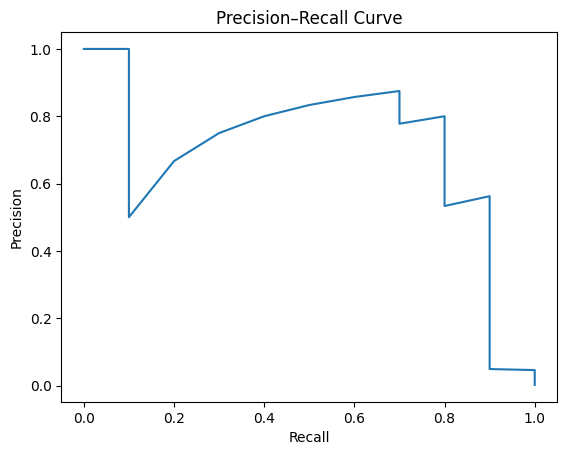

In [103]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_cal)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

In [77]:
scores = pd.DataFrame({'threshold':thresholds,
                       'precision': precision[:-1],
                       'recall':recall[:-1]}) # Store in a dataframe
scores.head(30)

,threshold,precision,recall
0,0.000516,0.001755,1.0
1,0.000525,0.032468,1.0
2,0.000527,0.038023,1.0
3,0.000531,0.045872,1.0
4,0.000535,0.048913,0.9
5,0.000537,0.059603,0.9
6,0.000537,0.061644,0.9
7,0.000540,0.063830,0.9
8,0.000541,0.067164,0.9
9,0.000542,0.067669,0.9


In [78]:
#Pick the smallest threshold that gives recall ≥ 0.90
import numpy as np

target = 0.90
idx = np.where(recall >= target)[0]

if len(idx) == 0:
    print("No threshold gives recall ≥ 90%")
else:
    threshold_opt = thresholds[idx[0]]   # smallest threshold meeting target recall
    print("Threshold for recall ≥ 90%:", threshold_opt)

Threshold for recall ≥ 90%: 0.0005159521716229015


In [79]:
#Make final predictions using the chosen threshold
y_pred_final = (y_pred_prob_cal >= threshold_opt).astype(int)
print("\nFinal Precision:", precision_score(y_test, y_pred_final))
print("Final Recall:", recall_score(y_test, y_pred_final))
print("Final F1:", f1_score(y_test, y_pred_final))


Final Precision: 0.00175530981218185
Final Recall: 1.0
Final F1: 0.0035044681969511127


In [80]:
results_df = pd.DataFrame({"actual": y_test,
                           "predicted": y_pred_final}) #Store results in a dataframe

confusion_matrix_final = pd.crosstab(index= results_df['actual'],
                               columns = results_df['predicted'])
confusion_matrix_final

predicted,1
actual,
0,5687
1,10
